# Prva laboratorijska vježba iz Dubokog učenja

### Gradijenti višeslojnih mreža, uvod u Tensorflow, potpuno povezani duboki modeli, studija slučaja: MNIST

## 1. Generiranje linearno nerazdvojivih podataka

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from numpy.random import normal
from scipy import stats as stats
import tensorflow as tf

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pdb

In [3]:
def sample_gmm(ncomponents, nclasses, nsamples):
    # create the distributions and groundtruth labels
    Gs=[]
    Ys=[]
    for i in range(ncomponents):
        Gs.append(Random2DGaussian())
        Ys.append(np.random.randint(nclasses))

    # sample the dataset
    X = np.vstack([G.get_sample(nsamples) for G in Gs])
    Y_= np.hstack([[Y]*nsamples for Y in Ys])

    return X,Y_

def sample_gmm_2d(K, C, N, one_hot=False):
    Gs = [Random2DGaussian() for i in range(K)]
    G_labels = np.random.randint(0, C, K)

    X = np.array([g.get_sample(N) for g in Gs]).reshape(-1, 2)
    Y = np.repeat(G_labels, N)
    if one_hot:
        return X, Y, _as_one_hot(C, Y)
    return X, Y

def _as_one_hot(C, Y):
    n = len(Y)
    Yoh = np.zeros((n, C))
    Yoh[range(n), Y] = 1
    return Yoh

class Random2DGaussian:
    """
    Random bivariate normal distribution sampler

    Hardwired parameters:
      d0min,d0max: horizontal range for the mean
      d1min,d1max: vertical range for the mean
      scalecov: controls the covariance range 

    Methods:
      __init__: creates a new distribution

      get_sample(n): samples n datapoints

    """
    d0min=0 
    d0max=10
    d1min=0 
    d1max=10
    scalecov=5
  
    def __init__(self):
        dw0,dw1 = self.d0max-self.d0min, self.d1max-self.d1min
        mean = (self.d0min,self.d1min)
        mean += np.random.random_sample(2)*(dw0, dw1)
        eigvals = np.random.random_sample(2)
        eigvals *= (dw0/self.scalecov, dw1/self.scalecov)
        eigvals **= 2
        theta = np.random.random_sample()*np.pi*2
        R = [[np.cos(theta), -np.sin(theta)], 
             [np.sin(theta), np.cos(theta)]]
        Sigma = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
        self.get_sample = lambda n: np.random.multivariate_normal(mean,Sigma,n)
        
def graph_surface(function, rect, offset=0.5, width=256, height=256):
    """
    Creates a surface plot (visualize with plt.show)

    Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
              ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

    Returns:
    None
    """

    lsw = np.linspace(rect[0][1], rect[1][1], width) 
    lsh = np.linspace(rect[0][0], rect[1][0], height)
    xx0,xx1 = np.meshgrid(lsh, lsw)
    grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)
    

    #get the values and reshape them
    values=function(grid).reshape((width,height))

    # fix the range and offset
    delta = offset if offset else 0
    maxval=max(np.max(values)-delta, - (np.min(values)-delta))

    # draw the surface and the offset
    plt.pcolormesh(xx0, xx1, values, 
    vmin=delta-maxval, vmax=delta+maxval)

    if offset != None:
        plt.contour(xx0, xx1, values, colors='black', levels=[offset])

def graph_data(X,Y_, Y, special=[]):
    """Creates a scatter plot (visualize with plt.show)

    Arguments:
      X:       datapoints
      Y_:      groundtruth classification indices
      Y:       predicted class indices
      special: use this to emphasize some points

    Returns:
      None
    """
    # colors of the datapoint markers
    palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
    colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
    for i in range(len(palette)):
        colors[Y_==i] = palette[i]

    # sizes of the datapoint markers
    sizes = np.repeat(20, len(Y_))
    sizes[special] = 60

    # draw the correctly classified datapoints
    good = (Y_==Y)
    plt.scatter(X[good,0],X[good,1], c=colors[good], 
              s=sizes[good], marker='o')

    # draw the incorrectly classified datapoints
    bad = (Y_!=Y)
    plt.scatter(X[bad,0],X[bad,1], c=colors[bad], 
              s=sizes[bad], marker='s')
    
def myDummyDecision(X):
    scores = X[:,0] + X[:,1] - 5
    return scores

def eval_perf_binary(Y, Y_):
    tp = sum(np.logical_and(Y==Y_, Y_==True))
    fn = sum(np.logical_and(Y!=Y_, Y_==True))
    tn = sum(np.logical_and(Y==Y_, Y_==False))
    fp = sum(np.logical_and(Y!=Y_, Y_==False))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp+fn + tn+fp)
    return accuracy, recall, precision

def eval_perf_multi(Y, Y_):
    pr = []
    n = max(Y_)+1
    M = np.bincount(n * Y_ + Y, minlength=n*n).reshape(n, n)
    for i in range(n):
        tp_i = M[i,i]
        fn_i = np.sum(M[i,:]) - tp_i
        fp_i = np.sum(M[:,i]) - tp_i
        tn_i = np.sum(M) - fp_i - fn_i - tp_i
        recall_i = tp_i / (tp_i + fn_i)
        precision_i = tp_i / (tp_i + fp_i)
        pr.append( (recall_i, precision_i) )

    accuracy = np.trace(M)/np.sum(M)

    return accuracy, pr, M

def eval_AP(ranked_labels):
    """Recovers AP from ranked labels"""

    n = len(ranked_labels)
    pos = sum(ranked_labels)
    neg = n - pos

    tp = pos
    tn = 0
    fn = 0
    fp = neg
  
    sumprec=0
    #IPython.embed()
    for x in ranked_labels:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)    

    if x:
        sumprec += precision
      
    #print (x, tp,tn,fp,fn, precision, recall, sumprec)
    #IPython.embed()

    tp -= x
    fn += x
    fp -= not x
    tn += not x

    return sumprec/pos
        
    

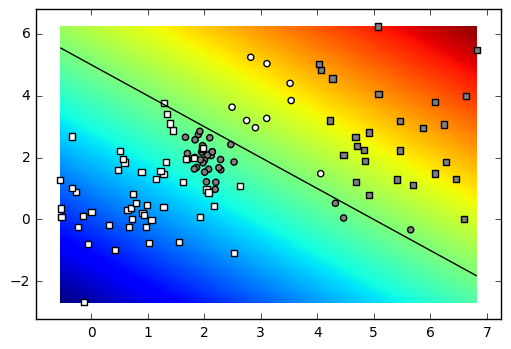

In [4]:
np.random.seed(100)

# get data
X,Y_ = sample_gmm(4, 2, 30)

# get the class predictions
Y = myDummyDecision(X)>0.5  

# graph the decision surface
rect=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(myDummyDecision, rect, offset=0)

# graph the data points
graph_data(X, Y_, Y, special=[])

plt.show()

## 2. Višeslojna klasifikacija u Pythonu

In [121]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

def softmax(output_array):
    output_array -= np.max(output_array)
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis=1, keepdims=True)

def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss

In [122]:
def fcann2_train(X, Y_):
    '''
       Argumenti
        X:  podatci, np.array NxD
        Y_: indeksi razreda, np.array Nx1

       Povratne vrijednosti
        layer1_weights_array, layer2_weights_array, layer1_biases_array, layer2_biases_array
    '''
    
    # labels one-hot encoding
    b = np.zeros((Y_.size, Y_.max()+1))
    b[np.arange(Y_.size),Y_] = 1
    
    Y_ = b
    
    hidden_nodes = 5
    num_labels = Y_.shape[1]
    num_features = X.shape[1]    
    
    layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
    layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

    layer1_biases_array = np.zeros((1, hidden_nodes))
    layer2_biases_array = np.zeros((1, num_labels))

    param_niter = 100001
    param_delta = 0.1
    param_lambda = 1e-3

    for step in range(param_niter):
        # forward pass
        input_layer = np.dot(X, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)
        
        loss = cross_entropy_softmax_loss_array(output_probs, Y_)
        loss += regularization_L2_softmax_loss(param_lambda, layer1_weights_array, layer2_weights_array)
        
        
        # backpropagation
        output_error_signal = (output_probs - Y_) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)
        
        #regularization
        gradient_layer2_weights += param_lambda * layer2_weights_array
        gradient_layer1_weights += param_lambda * layer1_weights_array

        layer1_weights_array -= param_delta * gradient_layer1_weights
        layer1_biases_array -= param_delta * gradient_layer1_bias
        layer2_weights_array -= param_delta * gradient_layer2_weights
        layer2_biases_array -= param_delta * gradient_layer2_bias
        
        if step % 5000 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))

    return layer1_weights_array, layer1_biases_array, layer2_weights_array, layer2_biases_array

def fcann2_classify(X, layer1_weights_array, layer1_biases_array, layer2_weights_array, layer2_biases_array):
    input_layer = np.dot(X, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    probs = softmax(scores)

    classes = probs.copy()
    
    return classes[:,1]

def fcann2_decfun(l1_w, l1_b, l2_w, l2_b):
    def classify(X):
        return fcann2_classify(X, l1_w, l1_b, l2_w, l2_b)
    return classify

In [123]:
np.random.seed(100)

# get the training dataset
X,Y_ = sample_gmm(6, 2, 10)

# train the model
l1_w, l1_b, l2_w, l2_b = fcann2_train(X, Y_)

# evaluate the model on the training dataset
probs = fcann2_classify(X, l1_w, l1_b, l2_w, l2_b)

Loss at step 0: 1.0170315795659621
Loss at step 5000: 0.46061018612750737
Loss at step 10000: 0.29084233780105495
Loss at step 15000: 0.2880151096541896
Loss at step 20000: 0.28705221840189127
Loss at step 25000: 0.2866027548668231
Loss at step 30000: 0.2863470134478185
Loss at step 35000: 0.25909142144772834
Loss at step 40000: 0.2586347213400092
Loss at step 45000: 0.2585708702330646
Loss at step 50000: 0.25854218192385764
Loss at step 55000: 0.2584795596420517
Loss at step 60000: 0.2584779159604519
Loss at step 65000: 0.25842228335716866
Loss at step 70000: 0.2584459983450603
Loss at step 75000: 0.2584205245318186
Loss at step 80000: 0.25840399318715884
Loss at step 85000: 0.2584027129395397
Loss at step 90000: 0.2584203821596601
Loss at step 95000: 0.2584078769967166
Loss at step 100000: 0.2583687255444237


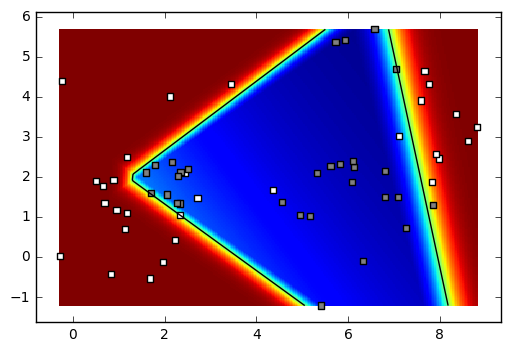

In [124]:
decfun = fcann2_decfun(l1_w, l1_b, l2_w, l2_b)
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(X, Y_, probs, special=[])

# show the plot
plt.show()

## 3. Linearna regresija u Tensorflowu

a: -0.767974 b: 0.0713359 loss: 139.539
[[ 76.79736328   0.        ]
 [ -7.1335907    0.        ]]
76.7974 -7.13359

a: -2.17067 b: 3.05546 loss: 42.7381
[[-0.05740803 -2.17123985]
 [-1.74736011  3.03798747]]
-0.0574083 -1.74736

a: -2.13408 b: 4.16897 loss: 41.3817
[[-0.0217849  -2.13430047]
 [-0.66295874  4.16233969]]
-0.0217853 -0.662959

a: -2.1202 b: 4.59144 loss: 41.1864
[[-0.00826305 -2.12028527]
 [-0.25153142  4.58892488]]
-0.00826237 -0.251531

a: -2.11494 b: 4.75173 loss: 41.1583
[[ -3.13407183e-03  -2.11496782e+00]
 [ -9.54316705e-02   4.75077534e+00]]
-0.00313488 -0.0954317

a: -2.11294 b: 4.81254 loss: 41.1542
[[ -1.19626522e-03  -2.11295056e+00]
 [ -3.62062827e-02   4.81218243e+00]]
-0.00119575 -0.0362063

a: -2.11218 b: 4.83562 loss: 41.1537
[[ -4.53174114e-04  -2.11218500e+00]
 [ -1.37371793e-02   4.83547926e+00]]
-0.000452118 -0.0137373

a: -2.11189 b: 4.84437 loss: 41.1536
[[ -1.71661377e-04  -2.11189461e+00]
 [ -5.21266460e-03   4.84431791e+00]]
-0.000171242 -0.00521

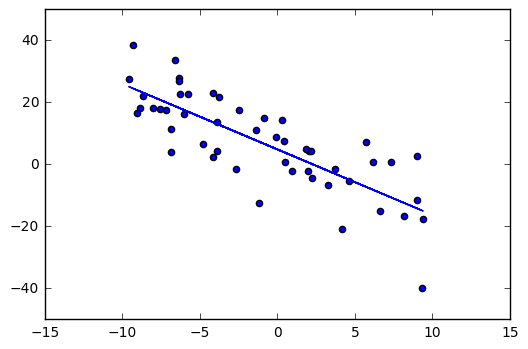

In [6]:
f = lambda x: -2*x + 5

# generiranje više primjera
np.random.seed(42)
Xs = np.random.uniform(-10, 10, 50)
Ys = f(Xs) + normal(0, 10, len(Xs))
Xs, Ys = Xs.reshape(-1, 1), Ys.reshape(-1, 1)
N = len(Xs)

# podatci i parametri
X  = tf.placeholder(tf.float32, [None, 1])
Y_ = tf.placeholder(tf.float32, [None, 1])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

# afini regresijski model
Y = a*X + b

# kvadratni gubitak
loss  = (1./(2*N)) * (Y-Y_)**2

trainer = tf.train.GradientDescentOptimizer(0.01)
train_op = trainer.minimize(loss)
grads_and_vars = trainer.compute_gradients(loss, [a, b])
optimize = trainer.apply_gradients(grads_and_vars)
grads_and_vars = tf.Print(grads_and_vars, [grads_and_vars], 'Status:')

grad_a = (1/N) * tf.matmul(Y - Y_, X, transpose_a=True)
grad_b = (1/N) * tf.reduce_sum(Y - Y_)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        val_loss, val_grads, da, db = sess.run([loss, grads_and_vars, grad_a, grad_b], feed_dict={X: Xs, Y_: Ys})
        sess.run(train_op, feed_dict={X: Xs, Y_: Ys})
        val_a, val_b= sess.run([a, b], feed_dict={X: Xs, Y_: Ys})

        if i% 100 == 0:
            print("a:", val_a, "b:", val_b, "loss:", val_loss.sum())
            print(val_grads)
            print(da[0][0], db)
            print()
            
    plt.scatter(Xs, Ys, marker='o')
    plt.plot(Xs, val_a*Xs + val_b, '-')
    plt.show()

## 4. Logistička regresija u Tensorflowu

In [6]:
class TFLogreg:
    def __init__(self, D, C, param_delta=0.01, param_lambda = 0.02):
    # definicija podataka i parametara:
    # definirati self.X, self.Yoh_, self.W, self.b
        self.X  = tf.placeholder(tf.float32, [None, D])
        self.Yoh_ = tf.placeholder(tf.float32, [None, C])
        self.W = tf.Variable(tf.random_normal([D, C]))
        self.b = tf.Variable(tf.random_normal([1, C]))
        self.learning_rate = param_delta
        self.regularization_lambda = param_lambda

    # formulacija modela: izračunati self.probs
    #   koristiti: tf.matmul, tf.nn.softmax
        self.probs = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b)

    # formulacija gubitka: self.loss
    #   koristiti: tf.log, tf.reduce_sum, tf.reduce_mean        
        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_*tf.log(self.probs), reduction_indices=1))
        self.regularizer = self.regularization_lambda * tf.nn.l2_loss(self.W)
        self.loss = self.cross_entropy + self.regularizer

    # formulacija operacije učenja: self.train_step
    #   koristiti: tf.train.GradientDescentOptimizer,
    #              tf.train.GradientDescentOptimizer.minimize
        self.train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)

    # instanciranje izvedbenog konteksta: self.session
    #   koristiti: tf.Session
        self.session = tf.Session()

    def train(self, X, Yoh_, param_niter):
    # incijalizacija parametara
    #   koristiti: tf.initialize_all_variables
        self.session.run(tf.global_variables_initializer())

    # optimizacijska petlja
    #   koristiti: tf.Session.run
        for i in range(param_niter):
            self.session.run(self.train_step, feed_dict={self.X:X, self.Yoh_:Yoh_})
            if i % 1000 == 0:
                loss = self.session.run(self.loss, feed_dict={self.X: X, self.Yoh_:Yoh_})
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def eval(self, X):
    #   koristiti: tf.Session.run
        probs = self.session.run(self.probs, feed_dict={self.X: X})
        return probs
    
def evaluate_performance(Y, Y_):   
    accuracy = accuracy_score(Y_, Y)
    precision = precision_score(Y_, Y)
    recall = recall_score(Y_, Y)
    f1 = f1_score(Y_, Y)
    print("Accuracy: {0:.3f}\n"
          "Precision: {1:.3f}\n"
          "Recall: {2:.3f}\n"
          "F1: {3:.3f}".format(accuracy, precision, recall, f1))
        
def tflogreg_decfun(tflogreg):
    def classify(X):
        return tf_classify(X, tflogreg)
    return classify
    
def tf_classify(X, tflogreg):
        return np.argmax(tflogreg.eval(X), axis=1)

In [12]:
np.random.seed(100)
tf.set_random_seed(100)

# instanciraj podatke X i labele Yoh_
X,Y_ = sample_gmm(4, 3, 10)
b = np.zeros((Y_.size, Y_.max()+1))
b[np.arange(Y_.size),Y_] = 1
Yoh_ = b

# izgradi graf:
tflr = TFLogreg(X.shape[1], Yoh_.shape[1], 0.01)

# nauči parametre:
tflr.train(X, Yoh_, 20000)

# dohvati vjerojatnosti na skupu za učenje
probs = tflr.eval(X)

# ispiši performansu (preciznost i odziv po razredima)
eval_perf_multi(tf_classify(X, tflr), Y_)

   0. Loss: 6.47940159
1000. Loss: 0.68384677
2000. Loss: 0.61437327
3000. Loss: 0.58092469
4000. Loss: 0.56214565
5000. Loss: 0.55098271
6000. Loss: 0.54410833
7000. Loss: 0.53976083
8000. Loss: 0.53694940
9000. Loss: 0.53509462
10000. Loss: 0.53384721
11000. Loss: 0.53299212
12000. Loss: 0.53239423
13000. Loss: 0.53196764
14000. Loss: 0.53165686
15000. Loss: 0.53142560
16000. Loss: 0.53124994
17000. Loss: 0.53111404
18000. Loss: 0.53100687
19000. Loss: 0.53092104


(0.75,
 [(0.5, 0.55555555555555558),
  (0.80000000000000004, 0.72727272727272729),
  (0.90000000000000002, 1.0)],
 array([[ 5,  5,  0],
        [ 4, 16,  0],
        [ 0,  1,  9]]))

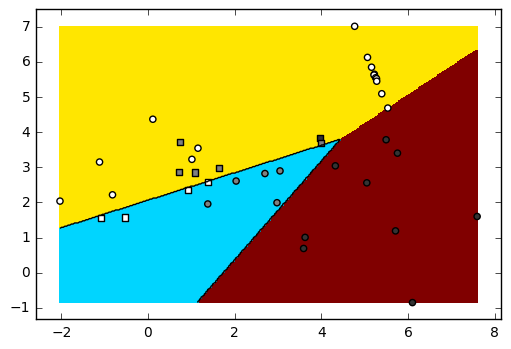

In [13]:
# iscrtaj rezultate, decizijsku plohu
decfun = tflogreg_decfun(tflr)
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(X, Y_, tf_classify(X, tflr), special=[])

# show the plot
plt.show()

## 5. Konfigurabilni duboki modeli u Tensorflowu

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def get_accuracy(nn, n_classes, X, Y_):
    probs = nn.eval(X)
    Y = probs.argmax(axis=1)

    print("Accuracy:", accuracy_score(Y, Y_))

    cnf_matrix = confusion_matrix(Y, Y_)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(0, n_classes))

In [5]:
class TFDeep:
    def __init__(self, config, param_delta, param_lambda=1e-4, activation=tf.nn.relu):
        D = config[0]
        C = config[-1]
        n_layers = len(config[1:])

        # data
        self.X  = tf.placeholder(tf.float32, [None, D])
        self.Yoh_ = tf.placeholder(tf.float32, [None, C])
        
        activations = [activation] * (n_layers-1) + [tf.nn.softmax]
        self.Ws = []
        self.bs = []

        reg_loss = 0
        prev_out = self.X
        for i, (prev, next) in enumerate(zip(config, config[1:])):
            W = tf.Variable(tf.random_normal([next, prev]), name='W%s' % i)
            b = tf.Variable(tf.random_normal([next]), name='b%s' % i)

            self.Ws.append(W)
            self.bs.append(b)
            reg_loss += tf.nn.l2_loss(W)
            
            s = tf.add(tf.matmul(prev_out, W, transpose_b=True), b)
                     
            prev_out = activations[i](s)

            

        # output
        self.probs = prev_out
        err_loss = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs + 1e-10), 1))
        self.loss = err_loss + param_lambda * reg_loss

        self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)
        
        self.session = tf.Session()



    def train(self, X, Yoh_, param_niter, printable=True):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # incijalizacija parametara
        self.session.run(tf.global_variables_initializer())

        # train loop
        for i in range(param_niter):
            val_loss, _ = self.session.run([self.loss, self.train_step], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 100 == 0 and printable: 
                print("{}\t{}".format(i, val_loss))
    
    def _shuffle(self, X, Yoh_):
        perm = np.random.permutation(len(X))
        return X[perm], Yoh_[perm]
        
    def _split_dataset(self, X, Yoh_, ratio=0.8):
        X, Yoh_ = self._shuffle(X, Yoh_)
        split = int(ratio * len(X))
        return X[:split], X[split:], Yoh_[:split], Yoh_[split:],
    
    def train_mb(self, X, Yoh_, n_epochs=1000, batch_size=64, train_ratio=0.8, print_step=100):
        self.session.run(tf.global_variables_initializer())
        prev_loss = window_loss = float('inf') 
        
        X_train, X_val, Y_train, Y_val = self._split_dataset(X, Yoh_, ratio=train_ratio)
        n_samples = len(X_train)
        n_batches = int(n_samples/batch_size)
        
        for epoch in range(n_epochs):
            X_train, Y_train = self._shuffle(X_train, Y_train)
            i = 0
            avg_loss = 0
            
            while i < n_samples:
                batch_X, batch_Yoh_ = X_train[i:i+batch_size], Y_train[i:i+batch_size]
                data_dict = {self.X: batch_X, self.Yoh_: batch_Yoh_}
                val_loss, _ = self.session.run([self.loss, self.train_step], feed_dict=data_dict)
                
                avg_loss += val_loss / n_batches
                i += batch_size
            
            # validation
            data_dict = {self.X: X_val, self.Yoh_: Y_val}
            val_loss, _ = self.session.run([self.loss, self.train_step], feed_dict=data_dict)
            window_loss = min(window_loss, val_loss)
            
            if epoch % 50 == 0:
                if window_loss > prev_loss:
                    print("Early stopping: epoch", epoch)
                    break
                prev_loss = window_loss
                window_loss = float('inf')
            
            if epoch % print_step == 0:
                print("Epoch: {:4d}; avg_train_loss {:.9f}; validation_loss {:.9f}".format(epoch, avg_loss, val_loss))
    
        print("Optimization Finished!")
        print("Validation loss {:.9f}".format(val_loss))
        
    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, {self.X: X})
        return probs

In [6]:
def count_params():
    total = 0
    for var in tf.trainable_variables():
        shape = var.get_shape()
        var_params = int(np.prod(shape))
        print('{}; shape: {}; total: {}'.format(var.name, shape, var_params))
        total += var_params
    print('Total:', total, "\n\n")

### [2, 3] logistic regression

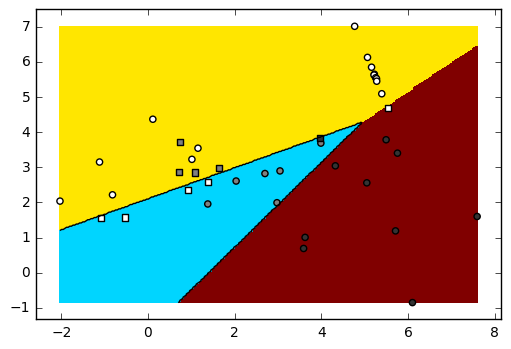

W0:0; shape: (3, 2); total: 6
b0:0; shape: (3,); total: 3
Total: 9 




0.75

In [172]:
np.random.seed(100)
tf.set_random_seed(100)

# instanciraj podatke X i labele Yoh_
X,Y_ = sample_gmm(4, 3, 10)
b = np.zeros((Y_.size, Y_.max()+1))
b[np.arange(Y_.size),Y_] = 1
Yoh_ = b

config9 = [2, 3]

tf.reset_default_graph()
nn9 = TFDeep(config9, 0.1, 1e-4, activation_function)
nn9.train(X, Yoh_, 10000, printable=False)

probs = nn9.eval(X)
Y = probs.argmax(axis=1)

decfun = lambda x: np.argmax(nn9.eval(x), axis=1)
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)
graph_data(X, Y_, Y)
plt.show()

count_params()
accuracy_score(Y, Y_)

### Sigmoid and ReLU

Activation function: ReLU
NN configuration: [2,2]


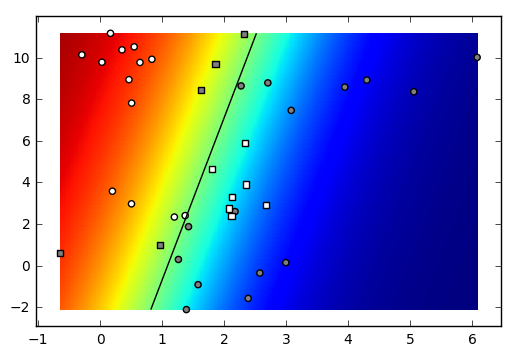

W0:0; shape: (2, 2); total: 4
b0:0; shape: (2,); total: 2
Total: 6 


Accuracy: 0.7


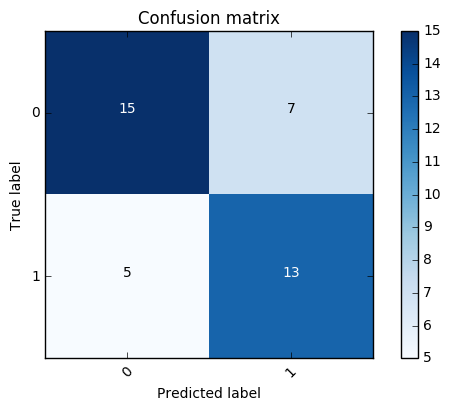

NN configuration: [2,10,2]


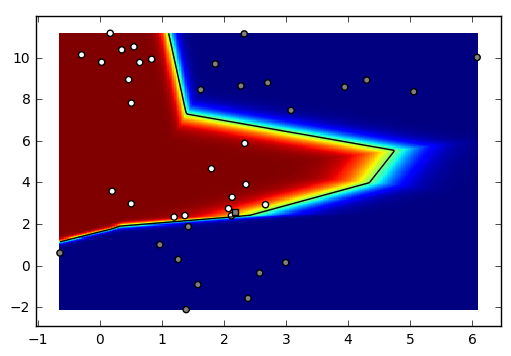

W0:0; shape: (10, 2); total: 20
b0:0; shape: (10,); total: 10
W1:0; shape: (2, 10); total: 20
b1:0; shape: (2,); total: 2
Total: 52 


Accuracy: 0.975


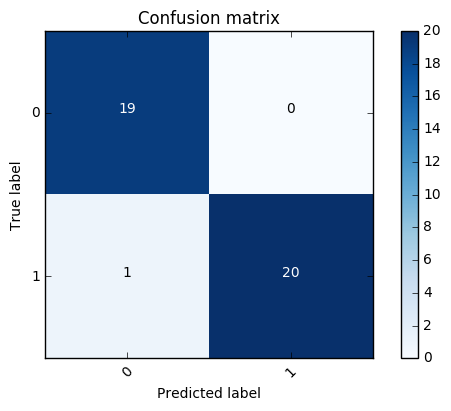

NN configuration: [2, 10, 10, 2]


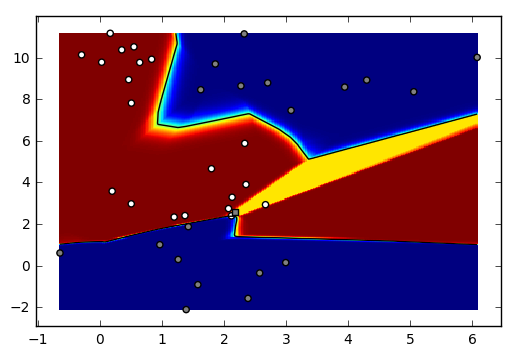

W0:0; shape: (10, 2); total: 20
b0:0; shape: (10,); total: 10
W1:0; shape: (10, 10); total: 100
b1:0; shape: (10,); total: 10
W2:0; shape: (10, 10); total: 100
b2:0; shape: (10,); total: 10
W3:0; shape: (2, 10); total: 20
b3:0; shape: (2,); total: 2
Total: 272 


Accuracy: 0.975


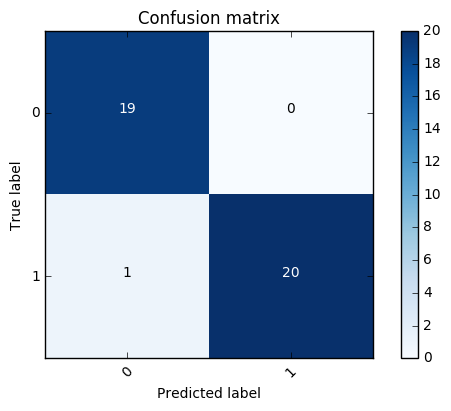

Activation function: Sigmoid
NN configuration: [2,2]


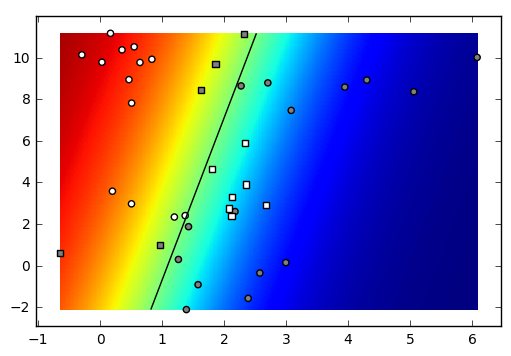

W0:0; shape: (2, 2); total: 4
b0:0; shape: (2,); total: 2
Total: 6 


Accuracy: 0.7


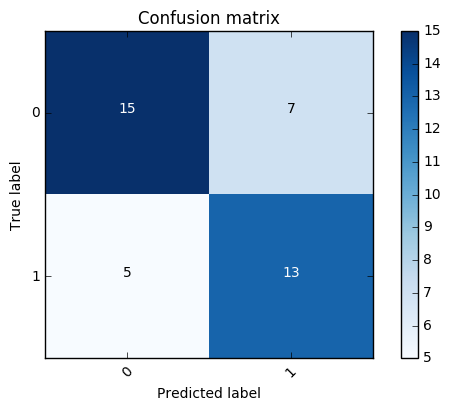

NN configuration: [2,10,2]


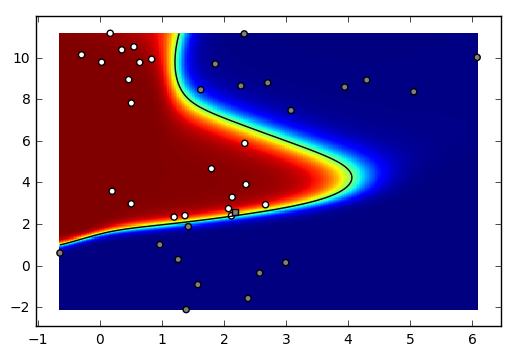

W0:0; shape: (10, 2); total: 20
b0:0; shape: (10,); total: 10
W1:0; shape: (2, 10); total: 20
b1:0; shape: (2,); total: 2
Total: 52 


Accuracy: 0.975


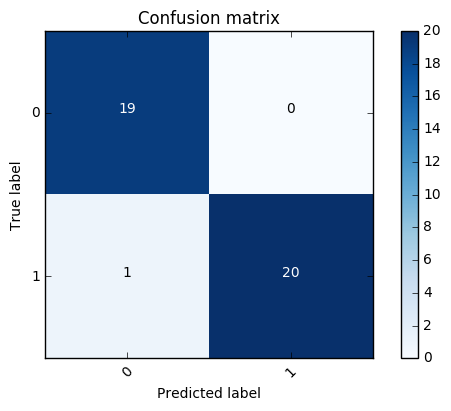

NN configuration: [2, 10, 10, 2]


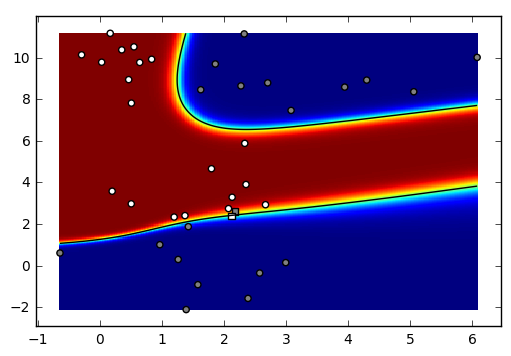

W0:0; shape: (10, 2); total: 20
b0:0; shape: (10,); total: 10
W1:0; shape: (10, 10); total: 100
b1:0; shape: (10,); total: 10
W2:0; shape: (10, 10); total: 100
b2:0; shape: (10,); total: 10
W3:0; shape: (2, 10); total: 20
b3:0; shape: (2,); total: 2
Total: 272 


Accuracy: 0.95


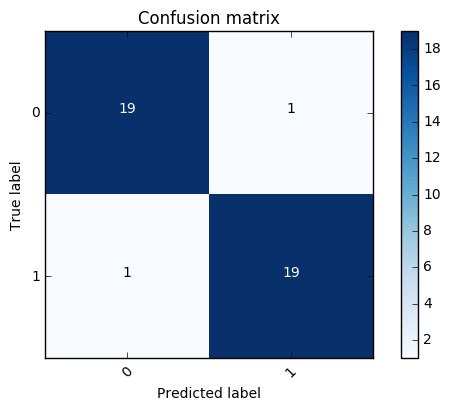

In [14]:
tf.set_random_seed(42)
np.random.seed(42)


X, Y_, Yoh_ = sample_gmm_2d(4, 2, 10, one_hot=True)

# [2,2]
config1 = [X.shape[1], Yoh_.shape[1]]

# [2,10,2]
config2 = [X.shape[1], 10, Yoh_.shape[1]]

# [2, 10, 10, 2]
config3 = [X.shape[1], 10, 10, 10, Yoh_.shape[1]]

activation_functions = ["ReLU", "Sigmoid"]
configurations = ["[2,2]", "[2,10,2]", "[2, 10, 10, 2]"]

i = 0
for activation_function in [tf.nn.relu, tf.nn.sigmoid]:
    print("Activation function:", activation_functions[i])
    i +=1 
    
    j = 0
    for config in [config1, config2, config3]:
        tf.reset_default_graph()
        
        print("NN configuration:", configurations[j])
        j += 1
        
        nn = TFDeep(config, 0.1, 1e-4, activation_function)
        nn.train(X, Yoh_, 10000, printable=False)

        probs = nn.eval(X)
        Y = probs.argmax(axis=1)
        
        decfun = lambda x: nn.eval(x)[:,1]
        bbox=(np.min(X, axis=0), np.max(X, axis=0))
        graph_surface(decfun, bbox, offset=0.5)
        graph_data(X, Y_, Y)
        plt.show()
        
        count_params()
        get_accuracy(nn, 2, X, Y_)

## 6. Usporedba s jezgrenim SVM-om

In [16]:
from sklearn.svm import SVC

class SVMWrapper:

    def __init__(self, X, Y_, c=1, g='auto'):
        self.model = SVC(gamma=g, C=c, probability=True)
        self.model.fit(X, Y_)

    def predict(self, X):
        return self.model.predict(X)

    def get_scores(self, X):
        return self.model.predict_proba(X)

    def support(self):
        return self.model.support_

SVM


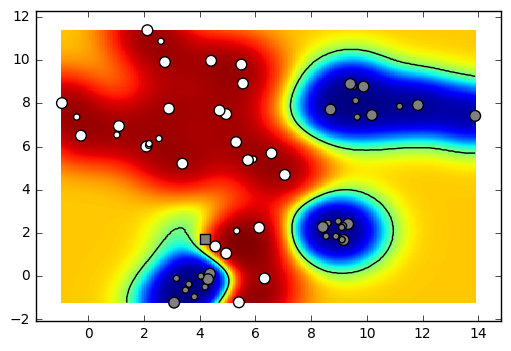

Accuracy: 0.983333333333


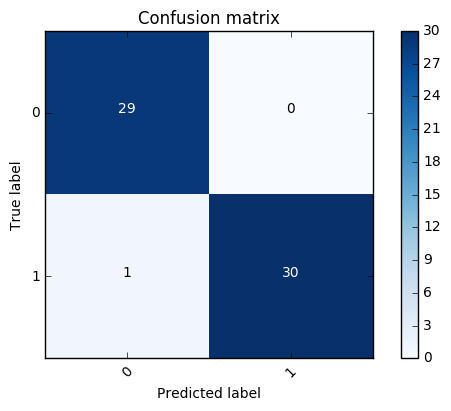

DNN


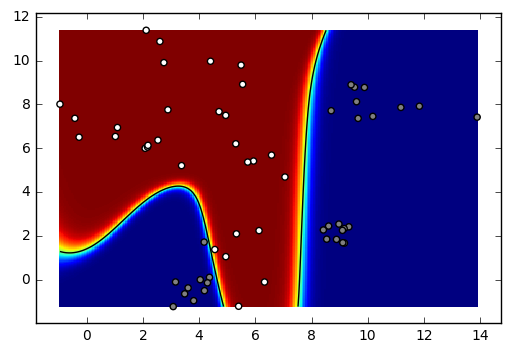

Accuracy: 1.0


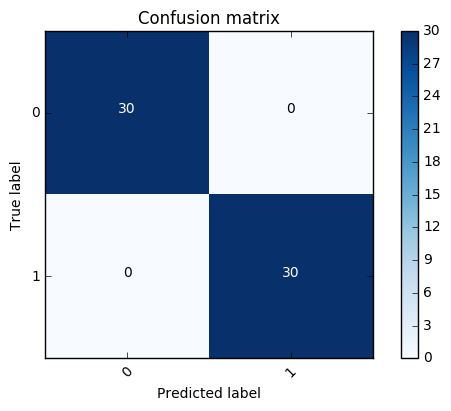

In [165]:
np.random.seed(100)

C = 2
n = 10
X, Y_, Yoh_ = sample_gmm_2d(6, 2, 10, one_hot=True)

model = SVMWrapper(X, Y_, c=1, g='auto')
decfun = lambda x: model.get_scores(x)[:,1]
probs = model.get_scores(X)
Y = probs.argmax(axis=1)

print("SVM")
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)
graph_data(X, Y_, Y, model.support())
plt.show()

print("Accuracy:", accuracy_score(Y, Y_))
cnf_matrix = confusion_matrix(Y, Y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(0, 2))


config = [X.shape[1], 10, 10, 10, Yoh_.shape[1]]


nn = TFDeep(config, 0.1, 1e-4, tf.nn.sigmoid )
nn.train(X, Yoh_, 10000, printable=False)

probs = nn.eval(X)
Y = probs.argmax(axis=1)

print("DNN")
decfun = lambda x: nn.eval(x)[:,1]
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)
graph_data(X, Y_, Y)
plt.show()

get_accuracy(nn, 2, X, Y_)

## 7. Studija slučaja: MNIST

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [7]:
tf.app.flags.DEFINE_string('data_dir', 
  '/tmp/data/', 'Directory for storing data')
mnist = input_data.read_data_sets(
  tf.app.flags.FLAGS.data_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Train:  N: 55000 D: 784 C: 10
Test:  N: 10000 D: 784 C: 10
(784,)


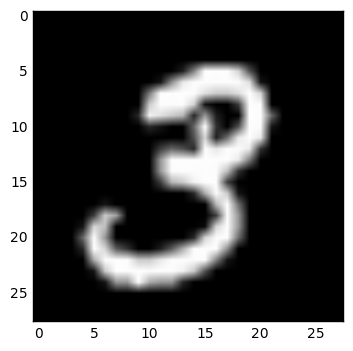

In [8]:
N = mnist.train.images.shape[0]
D = mnist.train.images.shape[1]
C = mnist.train.labels.shape[1]

print("Train:  N:", N, "D:", D, "C:", C)

N = mnist.test.images.shape[0]
D = mnist.test.images.shape[1]
C = mnist.test.labels.shape[1]

print("Test:  N:", N, "D:", D, "C:", C)
print(mnist.train.images[0].shape)
plt.imshow(mnist.train.images[1].reshape(28,28), cmap='gray')
plt.show()

### [784, 10] model

In [60]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config = [X.shape[1], Yoh_.shape[1]]

nn1 = TFDeep(config, 0.1, 1e-8)
nn1.train(X, Yoh_, 4001)

0	11.994070053100586
100	3.582510471343994
200	2.2519702911376953
300	1.8000458478927612
400	1.5592604875564575
500	1.4034759998321533
600	1.2915228605270386
700	1.2055383920669556
800	1.136584758758545
900	1.079656720161438
1000	1.0316475629806519
1100	0.9904612898826599
1200	0.9546167850494385
1300	0.9230411648750305
1400	0.8949449062347412
1500	0.8697391748428345
1600	0.8469608426094055
1700	0.8262538909912109
1800	0.8073243498802185
1900	0.7899360656738281
2000	0.7738922834396362
2100	0.7590325474739075
2200	0.7452182173728943
2300	0.732334315776825
2400	0.7202780842781067
2500	0.7089692950248718
2600	0.6983310580253601
2700	0.6883023381233215
2800	0.6788257360458374
2900	0.669853925704956
3000	0.661344587802887
3100	0.6532580256462097
3200	0.645564615726471
3300	0.6382331848144531
3400	0.6312355995178223
3500	0.6245495676994324
3600	0.6181536316871643
3700	0.6120272874832153
3800	0.6061526536941528
3900	0.6005141735076904
4000	0.5950958728790283


Accuracy: 0.8698


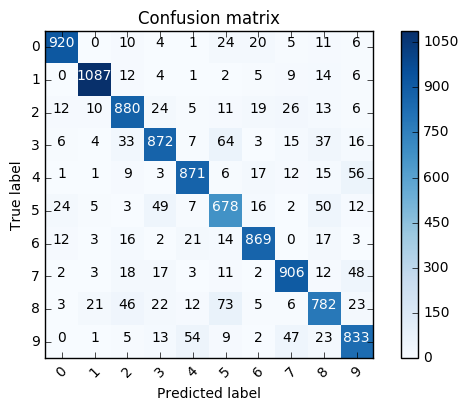

In [61]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn1, 10, X, Yoh_.argmax(1))

### [784, 100, 10] model

In [9]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config2 = [X.shape[1], 100, Yoh_.shape[1]]


nn2 = TFDeep(config2, 0.15, 1e-9)
nn2.train(X, Yoh_, 4001)

0	20.500558853149414
100	7.602940082550049
200	5.093924522399902
300	4.428762912750244
400	4.095555782318115
500	3.8943259716033936
600	3.752859354019165
700	3.64278507232666
800	3.555736780166626
900	3.4847702980041504
1000	3.423527956008911
1100	3.3688931465148926
1200	3.319200038909912
1300	3.273585557937622
1400	3.2308685779571533
1500	3.192453622817993
1600	3.158348321914673
1700	3.12778639793396
1800	3.100283622741699
1900	3.0745689868927
2000	3.050168037414551
2100	3.027121067047119
2200	3.0055699348449707
2300	2.9853556156158447
2400	2.9663567543029785
2500	2.9480884075164795
2600	2.930634021759033
2700	2.914351224899292
2800	2.8989627361297607
2900	2.8837177753448486
3000	2.8686981201171875
3100	2.84960675239563
3200	1.2993800640106201
3300	1.0478473901748657
3400	0.9417921900749207
3500	0.8746812343597412
3600	0.8251920938491821
3700	0.7850257158279419
3800	0.7511259913444519
3900	0.7218109369277954
4000	0.6961460113525391


Accuracy: 0.9228


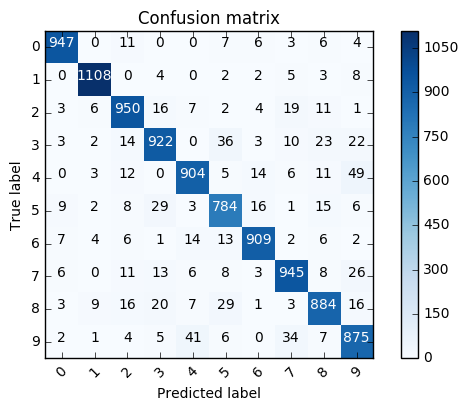

In [12]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn2, 10, X, Yoh_.argmax(1))

### Mini-batch training [784, 10]

In [101]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config3 = [784, 10]

nn3 = TFDeep(config3, 0.1, 1e-4)
nn3.train_mb(X, Yoh_, n_epochs=1000, batch_size=64, train_ratio=0.8, print_step=10)

Epoch:    0; avg_train_loss 2.749080457; validation_loss 1.569473982
Epoch:   10; avg_train_loss 0.771966456; validation_loss 0.812483311
Epoch:   20; avg_train_loss 0.623708584; validation_loss 0.674816012
Epoch:   30; avg_train_loss 0.540592714; validation_loss 0.592944145
Epoch:   40; avg_train_loss 0.483574893; validation_loss 0.536932111
Epoch:   50; avg_train_loss 0.441801025; validation_loss 0.495658994
Epoch:   60; avg_train_loss 0.409397312; validation_loss 0.461377978
Epoch:   70; avg_train_loss 0.383871216; validation_loss 0.438859254
Epoch:   80; avg_train_loss 0.363324320; validation_loss 0.416847587
Epoch:   90; avg_train_loss 0.346762504; validation_loss 0.401991576
Epoch:  100; avg_train_loss 0.332986228; validation_loss 0.386937499
Epoch:  110; avg_train_loss 0.321600857; validation_loss 0.378566682
Epoch:  120; avg_train_loss 0.312329675; validation_loss 0.367374957
Epoch:  130; avg_train_loss 0.304324453; validation_loss 0.362691820
Epoch:  140; avg_train_loss 0.2975

Accuracy: 0.9241


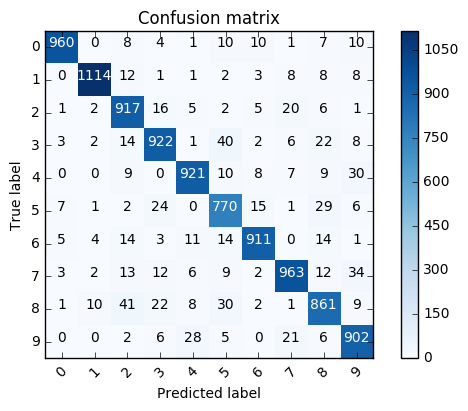

In [102]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn3, 10, X, Yoh_.argmax(1))

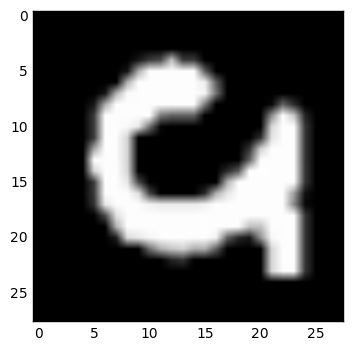

Prob 2.03398528242e-07
Correct label 9


In [139]:
probs = nn3.eval(mnist.test.images)
correct_probs = np.sum(probs * mnist.test.labels, axis=1)
worst_sample = correct_probs.argmin()
plt.imshow(mnist.test.images[worst_sample].reshape(28,28), cmap='gray')
plt.show()

print("Prob", correct_probs[worst_sample])
print("Correct label", mnist.test.labels[worst_sample].argmax())

### Mini-batch training [784, 100, 10]

In [103]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config6 = [784, 100, 10]

nn6 = TFDeep(config6, 0.1, 1e-4)
nn6.train_mb(X, Yoh_, n_epochs=1000, batch_size=64, train_ratio=0.8, print_step=10)

Epoch:    0; avg_train_loss 13.492376314; validation_loss 10.224004745
Epoch:   10; avg_train_loss 3.815790235; validation_loss 3.897318602
Epoch:   20; avg_train_loss 3.134841267; validation_loss 3.231016636
Epoch:   30; avg_train_loss 2.701230352; validation_loss 2.793980598
Epoch:   40; avg_train_loss 2.340778025; validation_loss 2.449364901
Epoch:   50; avg_train_loss 2.033004572; validation_loss 2.147338152
Epoch:   60; avg_train_loss 1.765952599; validation_loss 1.894682527
Epoch:   70; avg_train_loss 1.536435562; validation_loss 1.671816945
Epoch:   80; avg_train_loss 1.337825850; validation_loss 1.481570959
Epoch:   90; avg_train_loss 1.165534809; validation_loss 1.312144279
Epoch:  100; avg_train_loss 1.016821704; validation_loss 1.164819837
Epoch:  110; avg_train_loss 0.888032575; validation_loss 1.036855578
Epoch:  120; avg_train_loss 0.776480632; validation_loss 0.922114432
Epoch:  130; avg_train_loss 0.679557054; validation_loss 0.822966039
Epoch:  140; avg_train_loss 0.59

Accuracy: 0.9802


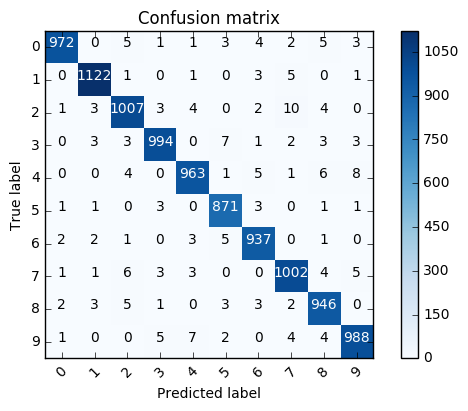

In [104]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn6, 10, X, Yoh_.argmax(1))

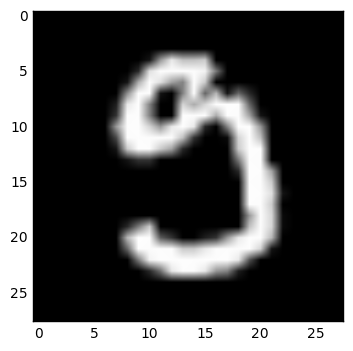

Prob 2.33286100411e-05
Correct label 9


In [127]:
probs = nn6.eval(mnist.test.images)
correct_probs = np.sum(probs * mnist.test.labels, axis=1)
worst_sample = correct_probs.argmin()
plt.imshow(mnist.test.images[worst_sample].reshape(28,28), cmap='gray')
plt.show()

print("Prob", correct_probs[worst_sample])
print("Correct label", mnist.test.labels[worst_sample].argmax())

### ADAM optimizer [784, 10]

In [92]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config5 = [784, 10]

nn5 = TFDeep(config5, 0.1, 1e-4)
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.1, global_step, 1, 1 - 1e-4, staircase=True)
nn5.train_step = tf.train.AdamOptimizer(learning_rate).minimize(nn5.loss, global_step=global_step)

nn5.train(X, Yoh_, 1001)

0	11.939597129821777
100	0.514260470867157
200	0.3266514539718628
300	0.2821817696094513
400	0.26834091544151306
500	0.26313507556915283
600	0.2616226375102997
700	0.260091632604599
800	0.273421049118042
900	0.25948426127433777
1000	0.2595860958099365


Accuracy: 0.9266


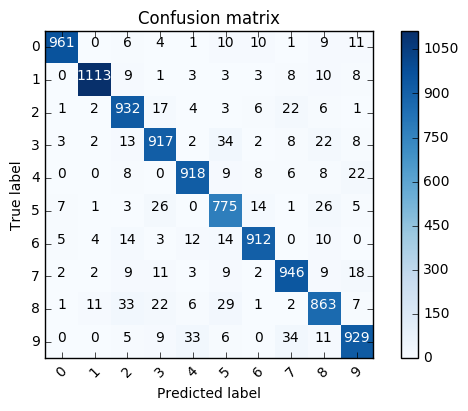

In [93]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn5, 10, X, Yoh_.argmax(1))

### ADAM optimizer mini-batch

In [107]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config4 = [784, 10]

nn4 = TFDeep(config4, 0.1, 1e-4)
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.1, global_step, 1, 1 - 1e-4, staircase=True)
nn4.train_step = tf.train.AdamOptimizer(learning_rate).minimize(nn4.loss, global_step=global_step)

nn4.train_mb(X, Yoh_, n_epochs=1000, batch_size=64, train_ratio=0.8, print_step=10)

Epoch:    0; avg_train_loss 1.402545186; validation_loss 1.123684645
Epoch:   10; avg_train_loss 0.749044766; validation_loss 0.693314373
Epoch:   20; avg_train_loss 0.449049941; validation_loss 0.436835915
Epoch:   30; avg_train_loss 0.343694282; validation_loss 0.372726679
Epoch:   40; avg_train_loss 0.298156372; validation_loss 0.329186529
Epoch:   50; avg_train_loss 0.276153427; validation_loss 0.320808440
Epoch:   60; avg_train_loss 0.265925552; validation_loss 0.310839713
Epoch:   70; avg_train_loss 0.260667165; validation_loss 0.310256869
Epoch:   80; avg_train_loss 0.258253989; validation_loss 0.308696479
Epoch:   90; avg_train_loss 0.256345487; validation_loss 0.308457047
Epoch:  100; avg_train_loss 0.255358477; validation_loss 0.308328390
Epoch:  110; avg_train_loss 0.254945342; validation_loss 0.307780504
Epoch:  120; avg_train_loss 0.254756729; validation_loss 0.307818562
Epoch:  130; avg_train_loss 0.254863658; validation_loss 0.307748497
Epoch:  140; avg_train_loss 0.2545

Accuracy: 0.9241


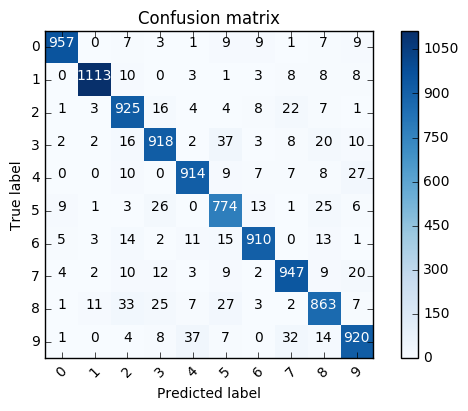

In [108]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn4, 10, X, Yoh_.argmax(1))

In [140]:
tf.reset_default_graph()
X, Yoh_ = mnist.train.images, mnist.train.labels
config7 = [784, 100, 10]

nn7 = TFDeep(config7, 0.1, 1e-4)
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.1, global_step, 1, 1 - 1e-4, staircase=True)
nn7.train_step = tf.train.AdamOptimizer(learning_rate).minimize(nn7.loss, global_step=global_step)

nn7.train_mb(X, Yoh_, n_epochs=1000, batch_size=64, train_ratio=0.8, print_step=10)

Epoch:    0; avg_train_loss 19.991630154; validation_loss 19.595998764
Epoch:   10; avg_train_loss 0.928525151; validation_loss 0.948234558
Epoch:   20; avg_train_loss 0.581629847; validation_loss 0.578212023
Epoch:   30; avg_train_loss 0.512720954; validation_loss 0.529345632
Epoch:   40; avg_train_loss 0.476315108; validation_loss 0.525012374
Epoch:   50; avg_train_loss 0.455467320; validation_loss 0.489272386
Epoch:   60; avg_train_loss 0.443458580; validation_loss 0.477627397
Epoch:   70; avg_train_loss 0.437616939; validation_loss 0.473723561
Epoch:   80; avg_train_loss 0.434245536; validation_loss 0.471071333
Epoch:   90; avg_train_loss 0.432433100; validation_loss 0.471465111
Epoch:  100; avg_train_loss 0.431519298; validation_loss 0.471040547
Epoch:  110; avg_train_loss 0.431164004; validation_loss 0.470906556
Epoch:  120; avg_train_loss 0.430639205; validation_loss 0.470935822
Epoch:  130; avg_train_loss 0.430327425; validation_loss 0.470899791
Epoch:  140; avg_train_loss 0.43

Accuracy: 0.8723


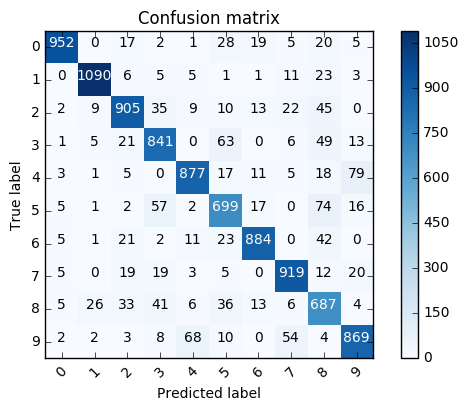

In [141]:
X, Yoh_ = mnist.test.images, mnist.test.labels
get_accuracy(nn7, 10, X, Yoh_.argmax(1))

### SVM comparison

In [ ]:
np.random.seed(100)
X, Yoh_ = mnist.train.images, mnist.train.labels
Y_ = Yoh_.argmax(axis=1)

model = SVMWrapper(X, Y_, c=1, g='auto')

Accuracy: 0.9439


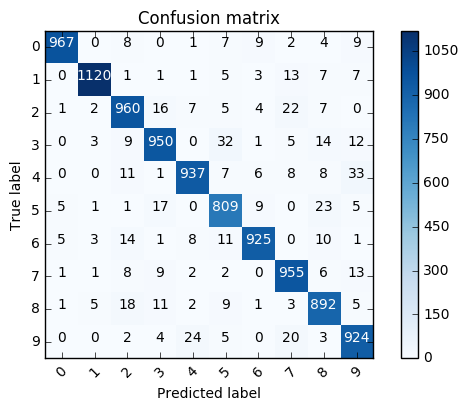

In [88]:
X, Yoh_ = mnist.test.images, mnist.test.labels
Y_ = Yoh_.argmax(axis=1)

probs = model.predict(X)
Y = probs

print("Accuracy:", accuracy_score(Y, Y_))
cnf_matrix = confusion_matrix(Y, Y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(0, 10))